In [1]:
# BrainNetCNN Implementation Version 1.0
# Software by Jeremy Kawahara and Colin J Brown
# Medical Image Analysis Lab, Simon Fraser University, Canada, 2017
# Implements the method described in: dx.doi.org/10.1016/j.neuroimage.2016.09.046

In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [172]:
%reload_ext autoreload
%autoreload 2
# sys.path.insert(0, os.path.join('/home/jer/projects/caffe/', 'python')) # If you don't have pycaffe in path.
import caffe
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..'))) # To import ann4brains if not installed.
from ann4brains.synthetic.injury import ConnectomeInjury
from ann4brains.nets import BrainNetCNN
from ann4brains.utils.metrics import regression_metrics

In [141]:
def plot_train_test_metrics(train_metrics, test_metrics):
    """Plot the train, test metrics."""

    itr = []
    #met_keys = test_metrics[0][1].keys()
    #mets = [[]]*len(met_keys)
    mad = []
    corr_0 = []
    corr_1 = []

    for met in E2Enet_sml.test_metrics:
        itr.append(met[0])
        #for m_key in met_keys:
        #    mets[0].append(met[1][m_key])
        mad.append(met[1]['mad'])
        corr_0.append(met[1]['corr_0'])
        corr_1.append(met[1]['corr_1'])
        
    fig, ax = plt.subplots()
    axes = [ax, ax.twinx()]
    axes[0].plot(train_metrics, color='purple', label='train loss')
    axes[0].plot(itr, mad, color='red', label='valid mad')
    axes[1].plot(itr, corr_0, color='blue', label='valid corr_0')
    axes[1].plot(itr, corr_1, color='green', label='valid corr_1')

    lines, labels = axes[0].get_legend_handles_labels()
    lines2, labels2 = axes[1].get_legend_handles_labels()
    axes[1].legend(lines + lines2, labels + labels2, loc='best')

<h1>Generate synthetic data</h1>

In [3]:
# Number of outputs.
n_injuries = 2 # NOTE: The synthetic code only works for 2 injuries right now.

n_samples = 100  # Number of training/testing samples.
noise_weight = 0.125  # How much to weigh the noise.

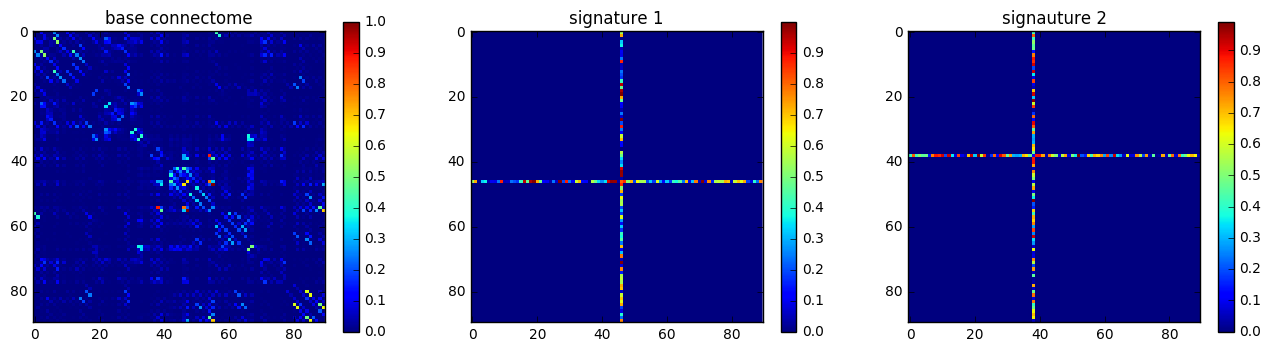

In [52]:
# Object to create synthetic injury data.
injury = ConnectomeInjury(base_filename=os.path.join('data', 'base.mat'), # Where the base matrix is.
                          n_injuries=n_injuries, # Only works for 2 injuries right now.
                          signature_seed=333, # Set the seed so we generate the same signatures.
                         ) 

# View the realistic base connectome and the injury signatures.
plt.figure(figsize=(16,4))
plt.subplot(1,3,1); plt.imshow(injury.X_mn, interpolation="None"); plt.colorbar(); plt.title('base connectome')
plt.subplot(1,3,2); plt.imshow(injury.sigs[0], interpolation="None"); plt.colorbar(); plt.title('signature 1')
plt.subplot(1,3,3); plt.imshow(injury.sigs[1], interpolation="None"); plt.colorbar(); plt.title('signauture 2')

In [9]:
# Generate train, validate, and test data
np.random.seed(seed=333) # To reproduce results.
x_train, y_train = injury.generate_injury(n_samples=1000, noise_weight=0.125)
x_test, y_test = injury.generate_injury(n_samples=1000, noise_weight=0.125)
x_valid, y_valid = injury.generate_injury(n_samples=1000, noise_weight=0.125)

In [43]:
print(x_train.shape) # 1000 samples of size 90 x 90 (1 since there's only 1 channel)
print(y_train.shape) # How much each of the 2 signatures weight the 1000 samples.

(1000, 1, 90, 90)
(1000, 2)


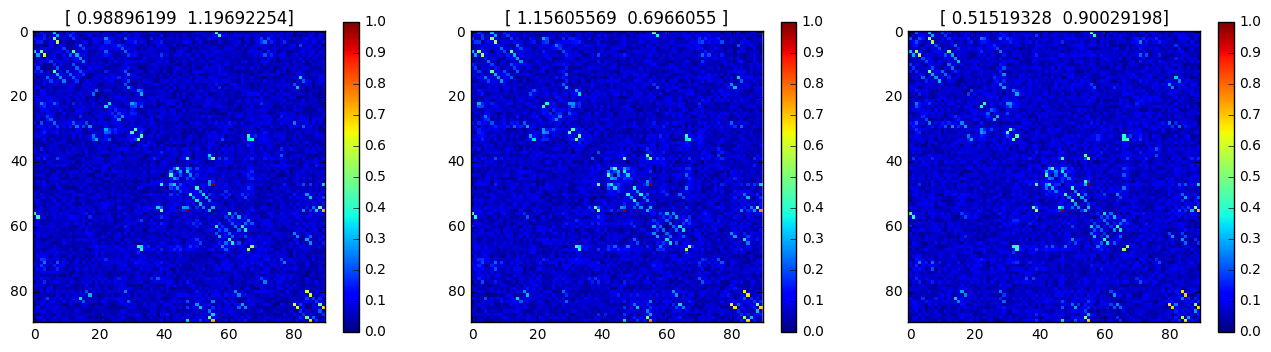

In [53]:
# Show example noisy training data that have the signatures applied.
# It's not obvious to the human eye the subtle differences, but the cross row and column above 
# perturbed the below matrices with the y weights.
plt.figure(figsize=(16,4))
for idx in range(3):
    plt.subplot(1,3,idx+1); plt.imshow(np.squeeze(x_train[idx]), interpolation="None"); plt.colorbar();
    plt.title(y_train[idx]) # How much each signature is weighted by.

In [59]:
# Spatial height and width of the data. 
h = x_train.shape[2]
w = x_train.shape[3]
print(h, w)

90 90


<h1>Edge-to-Edge test</h1>
<p>Example of using the Edge-to-Edge (E2E) layer along with an E2N layer.</p>

In [146]:
# Unique name for the model
net_name = 'E2Enet_sml'

# Specify the architecture.
e2e_arch = [
    ['e2e', # e2e layer 
     {'n_output': 16, # 16 feature maps 
      'kernel_h': h, 'kernel_w': w  # Sliding cross filter of size h x 1 by 1 x w
     }
    ], 
    ['e2n', {'n_output': 16, 'kernel_h': h, 'kernel_w': w}],
    ['dropout', {'dropout_ratio': 0.5}],
    ['relu',    {'negative_slope': 0.33}],
    ['fc',      {'n_output': 30}],
    ['relu',    {'negative_slope': 0.33}],
    ['out',     {'n_output': n_injuries}] 
]

# Create BrainNetCNN model
E2Enet_sml = BrainNetCNN(net_name, e2e_arch, 
                         hardware='gpu', # Or 'cpu'.
                         dir_data='./generated_synthetic_data', # Where to write the data to.
                        )

In [179]:
# Overwrite default parameters.
# Look at ann4brains.nets.
E2Enet_sml.pars['max_iter'] = 200 # Train the model for 100K iterations.
E2Enet_sml.pars['test_interval'] = 10 # Check the valid data every 500 iterations.
E2Enet_sml.pars['snapshot'] = 200 # Save the model weights every 10000 iterations.

In [180]:
# Train (optimize) the network.
E2Enet_sml.fit(x_train, y_train, x_valid, y_valid)  # If no valid data, you could put test data here to monitor.

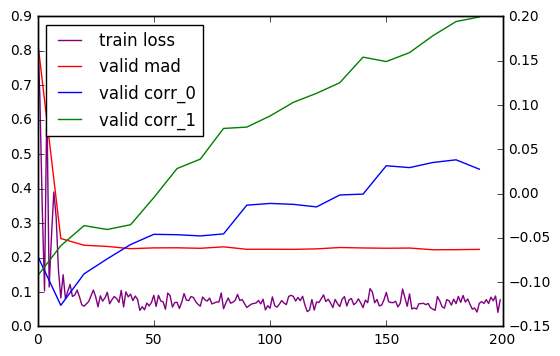

In [181]:
# Visualize the training loss, and valid metrics over training iterations.
plot_train_test_metrics(E2Enet_sml.train_metrics, E2Enet_sml.test_metrics)

In [182]:
# Predict labels of test data
preds = E2Enet_sml.predict(x_test)

In [183]:
print('E2E prediction results')
test_metrics_0 = regression_metrics(preds[:,0], y_test[:,0])
print('%s => mae: %.4f, corr: %.4f, p-val: %.4f' % ('class 0', test_metrics_0['mad'], test_metrics_0['corr_0'], test_metrics_0['p_0']))
test_metrics_0 = regression_metrics(preds[:,1], y_test[:,1])
print('%s => mae: %.4f, corr: %.4f, p-val: %.4f' % ('class 1', test_metrics_0['mad'], test_metrics_0['corr_0'], test_metrics_0['p_0']))

E2E prediction results
class 0 => mae: 0.2326, corr: 0.0872, p-val: 0.0058
class 1 => mae: 0.2193, corr: 0.2640, p-val: 0.0000


In [16]:
# Load the test data.
test_data = h5_utils.read_h5(hdf5_test, ['data', 'label'])

In [17]:
# Predict labels of test data
preds = E2Enet_sml.predict(test_data['data'])

In [18]:
# Print prediction results
print('E2E prediction results')
BrainNetCNN.print_results(preds, test_data['label'])

E2E prediction results
rho => mae: 0.2272, corr: 0.0591, p-val: 0.5595
rho => mae: 0.2520, corr: 0.0778, p-val: 0.4420
0.136802
